# Import Required Python Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import pickle
import time

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from glob import glob

# Setting GPU
(WARNING !! setting on my machine, maybe different with other)

In [2]:
# use local machine
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

## Check available device

In [3]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Directories

## Rename Files

In [4]:
# paths = (os.path.join(root, filename)
#         for root, _, filenames in os.walk('Dataset/masks/masks')
#         for filename in filenames)

# for path in paths:
#     # the '#' in the example below will be replaced by the '-' in the filenames in the directory
#     newname = path.replace('_mask', '')
#     if newname != path:
#         os.rename(path, newname)

## Split folder to train val test


### Split data to 80% train, 20% test

In [5]:
# import splitfolders
#
# splitfolders.ratio("Dataset/CXR_png", output="data", seed=1337, ratio=(.8, .2), group_prefix=None)
# splitfolders.ratio("Dataset/masks", output="data", seed=1337, ratio=(.8, .2), group_prefix=None)

### Split train data 90% train, 10% validation

In [6]:
# splitfolders.ratio("data/train/CXR_png", output="data/train/training", seed=1337, ratio=(.9, .1), group_prefix=None)
# splitfolders.ratio("data/train/masks", output="data/train/training", seed=1337, ratio=(.9, .1), group_prefix=None)

## Define segmentation directory

In [7]:
all_img = os.path.join('Dataset', 'CXR_png', 'CXR_png')
all_mask = os.path.join('Dataset', 'masks', 'masks')

input_dir = os.path.join('data')

train_dir = os.path.join(input_dir, 'train/training/train')
val_dir = os.path.join(input_dir, 'train/training/val')
test_dir = os.path.join(input_dir, 'test')

img_train_dir = os.path.join(train_dir, 'CXR_png')
img_val_dir = os.path.join(val_dir, 'CXR_png')
img_test_dir = os.path.join(test_dir, 'CXR_png')

mask_train_dir = os.path.join(train_dir, 'masks')
mask_val_dir = os.path.join(val_dir, 'masks')
mask_test_dir = os.path.join(test_dir, 'masks')

augmentation_dir = os.path.join(input_dir, 'Augmentation')

img_test_predict_dir = os.path.join(test_dir, 'predict')

# Create Helper function

In [8]:
def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def show_data(path, nheight=2, fheight=8, fweight=6):
    images = [i for i in os.listdir(path)]

    fig, axs = plt.subplots(nrows = nheight, ncols = 3, figsize=(fheight, fweight))

    for i in range(nheight):
        random_img = random.choice(images)
        image_file = os.path.join(all_img, random_img)
        mask_image_file = os.path.join(all_mask, random_img)

        image = cv2.imread(image_file)
        mask_image = cv2.imread(mask_image_file)
        merged_image = add_colored_mask(image, mask_image)
        
        image = cv2.resize(image, (512, 512))
        mask_image = cv2.resize(mask_image, (512, 512))
        merged_image = cv2.resize(merged_image, (512, 512))
        
        axs[i, 0].set_title(random_img)
        axs[i, 0].imshow(image)

        axs[i, 1].set_title("Mask")
        axs[i, 1].imshow(mask_image)

        axs[i, 2].set_title("Merged")
        axs[i, 2].imshow(merged_image)

# Check Dataset
displays the data to ensure that the image and masking are correct.

## Data Train

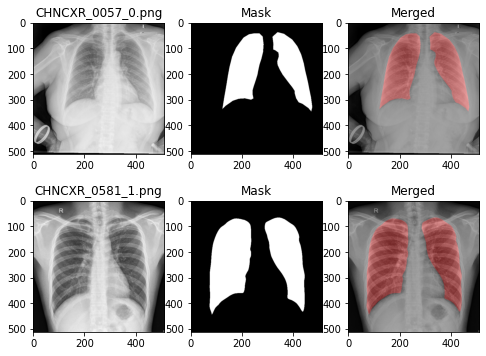

In [9]:
show_data("data/train/training/train/CXR_png")

## Data Val

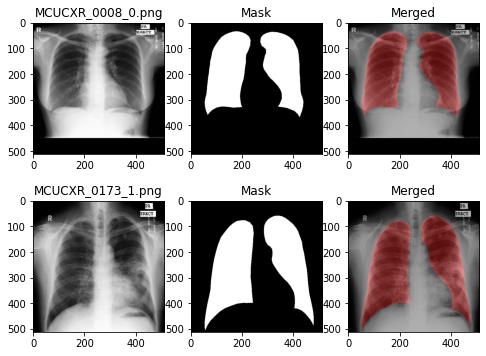

In [10]:
show_data("data/train/training/val/CXR_png")

## Data Test

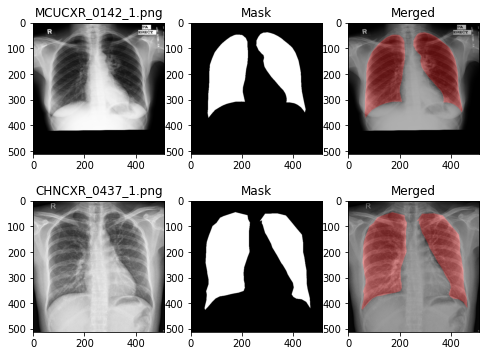

In [11]:
show_data("data/test/CXR_png")

In [12]:
train_img_files = glob(os.path.join(img_train_dir, "*.png"))
train_mask_files = glob(os.path.join(mask_train_dir, "*.png"))

val_img_files = glob(os.path.join(img_val_dir, "*.png"))
val_mask_files = glob(os.path.join(mask_val_dir, "*.png"))

test_img_files = glob(os.path.join(img_test_dir, "*.png"))
test_mask_files = glob(os.path.join(mask_test_dir, "*.png"))

In [14]:
print("img data train:", (len(train_img_files)), "|| mask data train:", (len(train_mask_files)))
print("img data val:", (len(val_img_files)), "|| mask data val:", (len(val_mask_files)))
print("img data test:", (len(test_img_files)), "|| mask data test:", (len(test_mask_files)))

# Generator for Image and Mask

In [14]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, 
                    train_path, 
                    image_folder, 
                    mask_folder, 
                    aug_dict,
                    image_color_mode="grayscale",
                    mask_color_mode="grayscale",
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,
                    target_size=(256,256),
                    seed=1):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield img, mask

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

In [15]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s%s" % (filename, fileext))

        cv2.imwrite(result_file, img)


## Batch size and Epoch

In [16]:
BATCH_SIZE=4

EPOCHS=200

In [17]:
train_generator_args = dict(width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            train_dir,
                            'CXR_png',
                            'masks', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir='data/Augmentation'
                           )

val_generator_args = dict()
val_gen = train_generator(BATCH_SIZE,
                          val_dir,
                          'CXR_png',
                          'masks',
                          train_generator_args,
                          target_size=(512,512),
                           )

# Training

In [18]:
# paper ref model

def net(input_size=(512,512,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

model = net(input_size=(512,512,1))

In [19]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [20]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [21]:
#inceptionv3 #mobilenet, #efficientnetb0

# backbone = 'efficientnetb0'
#
# model = sm.Unet(backbone,
#                 input_shape = (512, 512, 1),
#                 activation = 'sigmoid',
#                 classes = 1,
#                 encoder_weights = None)

backbone = 'paper_model'

In [30]:
model = net(input_size=(512,512,1))

In [22]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore, FScore

model.compile(optimizer = Adam(lr=0.0005),
              loss = DiceLoss(),
              metrics = [FScore(), IOUScore()] #FScore = dice, IoU = Jaccard
             )

time_callback = TimeHistory()

model_checkpoint = ModelCheckpoint('models/'+backbone+'t'+'.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

## Visualizing Keras Layer

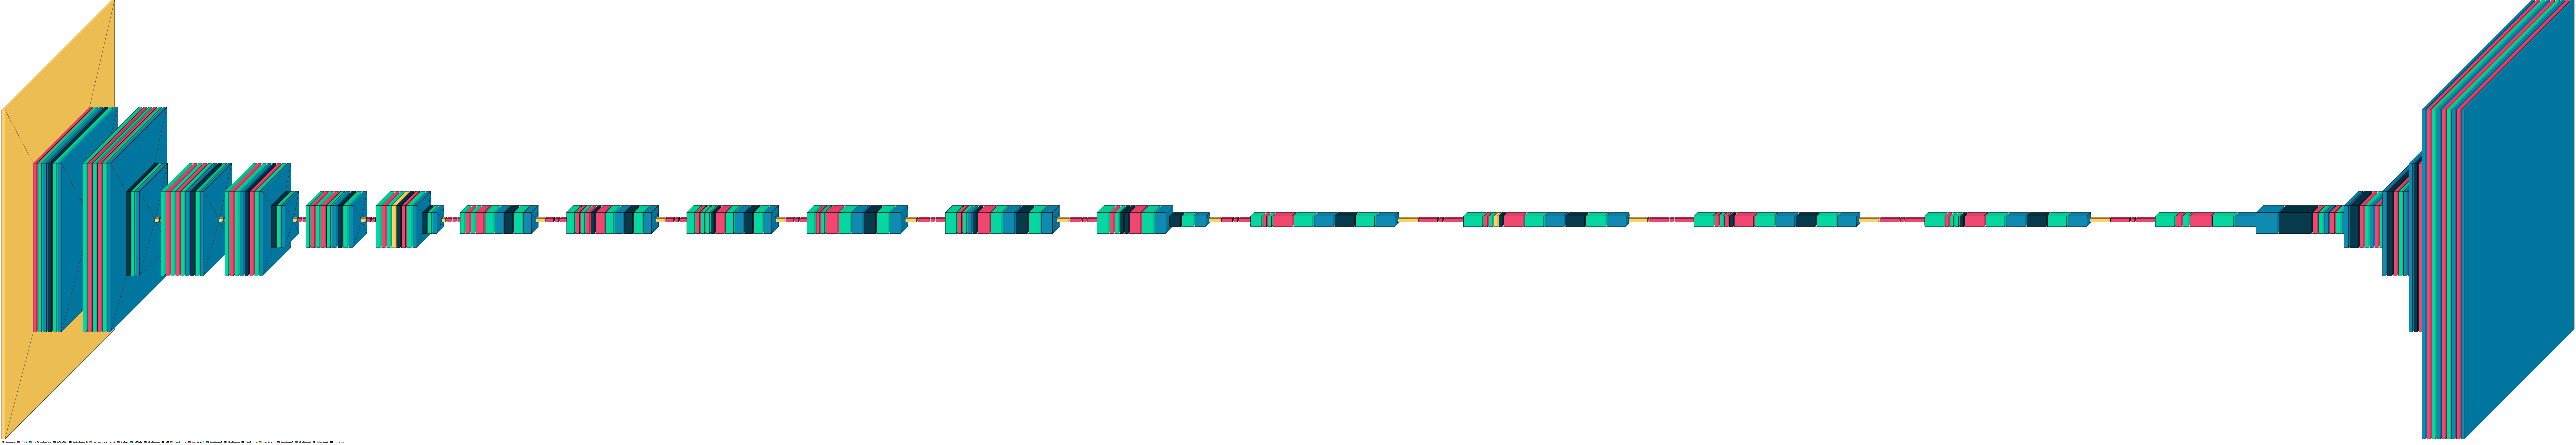

In [24]:
import visualkeras
visualkeras.layered_view(model, legend=True)

## Training

In [25]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_img_files) / BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[time_callback, model_checkpoint],
    validation_data = val_gen,
    validation_steps = len(val_img_files) / BATCH_SIZE
)

d:\sinau\lung segmentation keras\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1878: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 506 images belonging to 1 classes.
Found 506 images belonging to 1 classes.
Epoch 1/200
127/126 [==============================] - ETA: 0s - loss: 0.6079 - f1-score: 0.3921 - iou_score: 0.2454Found 57 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
126/126 [==============================] - 101s 683ms/step - loss: 0.6075 - f1-score: 0.3925 - iou_score: 0.2457 - val_loss: 0.5724 - val_f1-score: 0.4246 - val_iou_score: 0.2705

Epoch 00001: loss improved from inf to 0.55853, saving model to models\efficientnetb0t.hdf5
Epoch 2/200
126/126 [==============================] - 76s 607ms/step - loss: 0.4593 - f1-score: 0.5407 - iou_score: 0.3713 - val_loss: 0.5025 - val_f1-score: 0.5010 - val_iou_score: 0.3356

Epoch 00002: loss improved from 0.55853 to 0.43739, saving model to models\efficientnetb0t.hdf5
Epoch 3/200
126/126 [==============================] - 76s 606ms/step - loss: 0.3905 - f1-score: 0.6095 - iou_score: 0.4392 - val_loss: 0.4586 - val_f1-score: 0.54

## Save training time

In [ ]:
print("Training Time "+str(round(sum(time_callback.times) / 60, 1))+" Minutes")

In [ ]:
df = pd.DataFrame(time_callback.times)
df.to_csv('training time/'+backbone+'t'+'_training_time.csv',
          index=False,
          header=False)

## Save training loss history

In [26]:
with open('train history/'+backbone+'t'+'_trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)